<a href="https://colab.research.google.com/github/DayrisRM/VisionArtificial-M1/blob/main/AlexNet_US_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving US_Original_dataset_final.zip to US_Original_dataset_final.zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['US_Original_dataset_final.zip']), 'r')
data.extractall()

In [3]:
import os

In [4]:
train_path = '/content/US_Original_dataset_final/train/' 
test_path = '/content/US_Original_dataset_final/test/'

In [5]:
print('The training set consists of ', len(os.listdir(train_path + 'Benign/')), ' Benign images and '
, len(os.listdir(train_path + 'Malignant/')), ' Malignant images.' )

The training set consists of  68  Benign images and  30  Malignant images.


In [6]:
print('The test set consists of ', len(os.listdir(test_path + 'Benign/')), ' Benign images and '
, len(os.listdir(test_path + 'Malignant/')), ' Malignant images.' )

The test set consists of  26  Benign images and  14  Malignant images.


In [7]:
import cv2
from PIL import Image
import numpy as np

In [8]:
cates = ['Benign', 'Malignant']
def load_images_and_labels(data_path, cates): 
  X = []
  y = []
  i = 0
  for index, cate in enumerate(cates): 
    for img_name in os.listdir(data_path + cate + '/'):
      i = i +1
      img = cv2.imread(data_path + cate + '/' + img_name)
      img_array = Image.fromarray(img, 'RGB')
      # resize image to 227x227 which is the required input size of the Alexnet model
      img_rs = img_array.resize((227,227))
      # convert the image to array
      img_rs = np.array(img_rs)
      X.append(img_rs)
      y.append(index)
  return X, y

In [9]:
#Load the training data
X_train, y_train = load_images_and_labels(train_path, cates)

In [10]:
#Load the test data
X_test, y_test = load_images_and_labels(test_path, cates)

In [11]:
print('Training size: ', len(X_train), 'Testing size: ', len(X_test))

Training size:  98 Testing size:  40


In [12]:
#Save X_train, y_train, X_test, y_test
data_dict = {'X_train' : X_train, 
             'y_train': y_train, 
             'X_test': X_test, 
             'y_test': y_test}
np.save('data_dict.npy', data_dict)

In [13]:
#Load X_train, y_train, X_test, y_test
data_dict_ = np.load('data_dict.npy', allow_pickle = 'True').item()
X_train = data_dict_['X_train']
y_train = data_dict_['y_train']
X_test = data_dict_['X_test']
y_test = data_dict_['y_test']

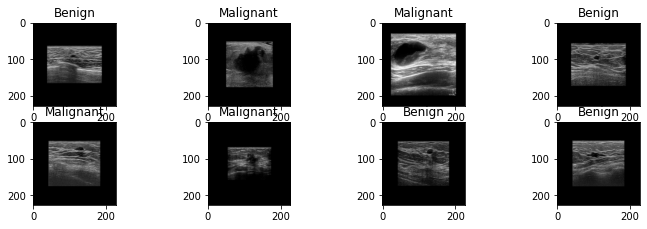

In [14]:
#Display randomly some images of the training set:

import matplotlib.pyplot as plt
import random
plt.figure(figsize = (12,7))
cate = ['Benign', 'Malignant']
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(440 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(cate[y_train[ind]])

In [15]:
from tensorflow.keras.utils import to_categorical
def preprocess_data(X, y):  
  # convert X from list to array
  X = np.array(X)  
  # convert integer values of X into floats
  X = X.astype(np.float32)
  # normalization 
  X = X/255.0  
  # one-hot encoding the labels 
  y = to_categorical(np.array(y))  
  return X, y

In [16]:
(X_train, y_train) = preprocess_data(X_train, y_train)
(X_test, y_test) = preprocess_data(X_test, y_test)

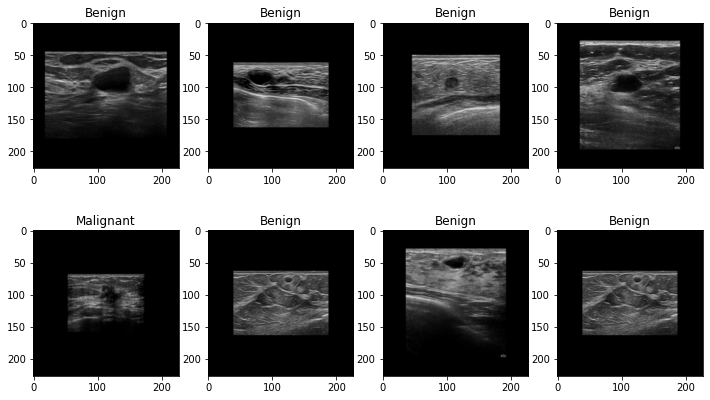

In [17]:
#Visualize some images of the training set after preprocessing:
plt.figure(figsize = (12,7))
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(cate[np.argmax(y_train[ind])])

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# metric
from keras.metrics import binary_crossentropy
# optimization method (Stochastic Gradient Descent (SGD))
from tensorflow.keras.optimizers import SGD

In [19]:
def Alexnet():
  # Initialize the model
  model = Sequential()

  # layer 1: convolutional layer + max-pooling layer
  model.add(Conv2D(filters = 96, kernel_size = (11,11), strides= 4, padding = 'valid'
  , activation='relu', input_shape = (227,227,3)))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layer 2: convolutional layer + max-pooling layer 
  model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 3-5: three convolutional layers + 1 max-pooling layer
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 6 - 8: two fully connected hidden layers and one fully connected output layer
  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation = 'softmax'))

  # compile the model with a loss funciton, a metric and and optimizqation method
  opt = SGD(lr = 0.1)
  model.compile(loss = binary_crossentropy,
                optimizer = opt,
                metrics = ['accuracy'])

  return model

In [20]:
Alexnet_model = Alexnet()
Alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [22]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
  # Data generator
  datagen = ImageDataGenerator(rotation_range = 5, width_shift_range = 0.1, 
                               height_shift_range = 0.1, horizontal_flip = True)
  # iteration on the training set
  it_train = datagen.flow(X_train, y_train, batch_size = batch_size)
 
  # Fitting the model  
  history = model.fit(it_train, steps_per_epoch=len(it_train),
		  validation_data = (X_test, y_test), epochs=100, verbose=1)
  
  # Evaluating the model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  
  return history, acc

In [23]:
train_history, acc = train_model(Alexnet_model, X_train, y_train, X_test, y_test, epochs = 100, batch_size = 128)

Epoch 1/100
1/1 [==============================] - 16s 16s/step - loss: 0.6919 - accuracy: 0.5306 - val_loss: 0.6865 - val_accuracy: 0.6500
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.6852 - accuracy: 0.6939 - val_loss: 0.6804 - val_accuracy: 0.6500
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.6794 - accuracy: 0.6939 - val_loss: 0.6745 - val_accuracy: 0.6500
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.6722 - accuracy: 0.6939 - val_loss: 0.6680 - val_accuracy: 0.6500
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.6652 - accuracy: 0.6939 - val_loss: 0.6607 - val_accuracy: 0.6500
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.6550 - accuracy: 0.6939 - val_loss: 0.6525 - val_accuracy: 0.6500
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 0.6434 - accuracy: 0.6939 - val_loss: 0.6452 - val_accuracy: 0.6500
Epoch 8/100
1/1 [===============

In [24]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
train_hist_df = pd.DataFrame(train_history.history) 

train_dict = {'train_hist': train_hist_df, 
              'acc': acc}
np.save('train_dict.npy', train_dict)   

In [25]:
Alexnet_model.save('Alexnet_model.h5')

In [26]:
def plot_accuracy(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

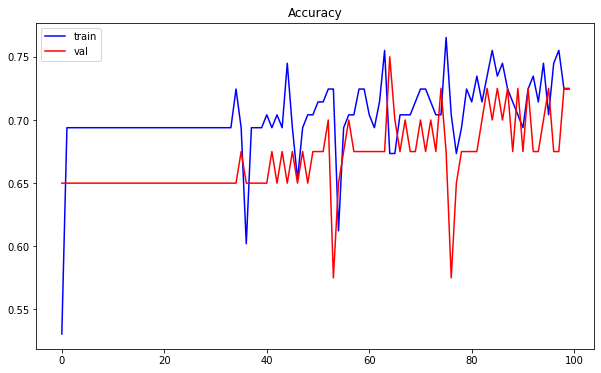

In [27]:
plot_accuracy(train_history)

In [28]:
#Prediction
y_test_pred = []
for i in np.arange(len(X_test)):
  img = X_test[i]
  img = img.reshape(1, 227, 227, 3)
  y_p = Alexnet_model.predict(img)
  y_test_pred.append(y_p)

y_test_pred = np.asarray(y_test_pred)

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

In [30]:
y_test_labels = [np.argmax(vect) for vect in y_test]
y_test_pred_labels = [np.argmax(vect) for vect in y_test_pred]

Text(69.0, 0.5, 'True classes')

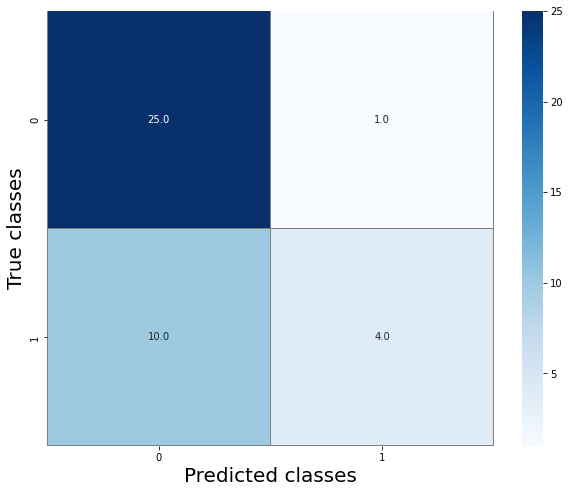

In [33]:
conf_mat = confusion_matrix(y_test_labels, y_test_pred_labels)

plt.figure(figsize = (10,8))
sns.heatmap(conf_mat, linewidths = 0.1, cmap = 'Blues', linecolor = 'gray', fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)